In [1002]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [1003]:
pd.options.display.max_rows = 999

#Exploring Sleep Debt

Literature shows that the type of good health I seek, that of a physically fit althete, can be examined at with the following rubric.

1. According to Wikipedia: "Sleep debt or sleep deficit is the cumulative effect of not getting enough sleep. A large sleep debt may lead to mental or physical fatigue. There are two kinds of sleep debt: the results of partial sleep deprivation and total sleep deprivation." 
2. Resting heart rate (RHR) can be the result of a high level of fitness, meditative breathing, and sleep. There are other reasons such as disease, diet, family history, and medication which can result in low resting heart rate. For my health purposes I expect to see that when I am healthy and doing self care (such as meditation, high cardio workouts, sleep hygiene, etc.) my resting heart rate will be relatively steady and if trends present themselves the RHR will be trending down.
3. 

In [1004]:
!pip install category_encoders
import category_encoders as ce

In [1005]:
pd.options.mode.chained_assignment = None

In [1006]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTMIUP6_JIoxWSAFCe1h6Hz12r-41t6qHv5cCXIBmYJUK2KS188pKkZnkr4jJRpIcC3mRZV36z21oNv/pub?gid=0&single=true&output=csv')

In [1007]:
header_list = ['Date','Weight','Fat','Sleep Debt','REM','Deep Sleep','Snore',
     'Meditate','Spanish','Push-ups','Pull-ups','Sit-ups','Coffee','Handstands',
     'Acro','Swing','Strain','Calories','AHR','MHR','HRV','RHR','Recovery',
     'Carbs','Journal','Spinal Mobility','Flexibility','Notes','DOW',
     'Weight_AVR','Fat_AVR','Sleep Debt_AVR','REM_AVR','Deep Sleep_AVR',
     'Strain_AVR','Calories_AVR','AHR_AVR','MHR_AVR','HRV_AVR','RHR_AVR',
     'Recovery_AVR','Weight_PASS','Fat_PASS','Sleep Debt_PASS','REM_PASS',
     'Deep Sleep_PASS','Strain_PASS','Calories_PASS','AHR_PASS','MHR_PASS',
     'HRV_PASS','RHR_PASS','Recovery_PASS']

In [1008]:
df = df.reindex(columns = header_list)

In [1009]:
df['Date'] = pd.to_datetime(df['Date'])

for i in range(len(df)):
    df['DOW'][i] = df['Date'][i].day_name()

In [1010]:
features = ['Weight','Fat','Sleep Debt','REM','Deep Sleep','Strain','Calories','AHR','MHR','HRV','RHR','Recovery']
special_features = ['Sleep Debt','AHR','RHR']
drops = ['Acro','Meditate','Snore','Coffee','Handstands','Spanish','Push-ups',
         'Pull-ups','Sit-ups','Swing','Carbs','Journal','Spinal Mobility',
         'Flexibility','Notes','DOW']
week_day = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

In [1011]:
for each in features:
    df[each] = df[each].interpolate(method='linear')

In [1012]:
for i in range(0,df.shape[0]-1):
    for j in range(len(features)):
        string = features[j] + '_ROLLING'
        df[string] = df.iloc[:,j+1].rolling(7,center=True,min_periods=1).mean()

In [1013]:
df['Rolling Sleep Debt'] = df.apply(
    lambda row: row['Sleep Debt_ROLLING'] if np.isnan(row['Sleep Debt']) else row['Sleep Debt'],
    axis=1
)

In [1014]:
df = df.drop(labels=drops,axis=1)

##Sleep Debt Quantiles

In [1015]:
df['Sleep Debt'].describe()

count    728.000000
mean      82.337912
std       25.320697
min        0.000000
25%       69.000000
50%       83.000000
75%       97.135870
max      192.000000
Name: Sleep Debt, dtype: float64

In [1016]:
df['Sleep Debt_ROLLING'].describe()

count    728.000000
mean      82.332369
std       16.315591
min       32.857143
25%       71.142857
50%       80.978261
75%       93.951630
max      138.250000
Name: Sleep Debt_ROLLING, dtype: float64

In [1017]:
for i in range(0,df.shape[0]-1):
    for j in range(len(features)):
        string = features[j] + '_AVR'
        df[string] = df.iloc[:,j+1].expanding(min_periods=7).mean()

for i in range(0,df.shape[0]-1):
    for j in range(len(features)):
        isnull = pd.isnull(df[j][i])
        if isnull == True:
            df[j][i] = df.iloc[:,j+1].expanding(min_periods=7).mean()

In [1018]:
for i in range(len(df)):
  for feat in features:
    score = feat + '_PASS'
    avr = feat + '_AVR'
    if feat not in special_features:
      if df[feat][i] >= df[avr][i]:
        df[score][i] = "Y"
      else:
        df[score][i] = "N"
    elif feat in special_features:
      if df[feat][i] <= df[avr][i]:
        df[score][i] = "Y"
      else:
        df[score][i] = "N"

In [1019]:
test = df[df['Date'] >= '11/29/2019']
train = df[df['Date'] <= '07/24/2019']
val = df[(df['Date'] <= '11/28/2019') & (df['Date'] >= '07/25/2019')]

In [1020]:
test.shape, train.shape, val.shape

((68, 50), (533, 50), (127, 50))

In [1021]:
target = 'Sleep Debt_PASS'
# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 25].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [1022]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [1023]:
y_train.value_counts(normalize=True)

Y    0.529081
N    0.470919
Name: Sleep Debt_PASS, dtype: float64

encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer(strategy='mean')
rf = RandomForestClassifier(max_features='sqrt',n_estimators=100,n_jobs=-1, random_state=42)
X_train = encoder.fit_transform(X_train)
X_val = encoder.fit_transform(X_val)
X_test = encoder.fit_transform(X_test)
#y_train = encoder.fit_transform(y_train)
#y_val = encoder.fit_transform(y_val)
#y_test = encoder.fit_transform(y_test)
X_train = imputer.fit_transform(X_train)
X_val = imputer.fit_transform(X_val)
X_test = imputer.fit_transform(X_test)
#y_train = imputer.fit_transform(y_train)
#y_val = imputer.fit_transform(y_val)
#y_test = imputer.fit_transform(y_test)
X_train = rf.fit(X_train,y_train)
X_val = rf.fit(X_val,y_val)
X_test = rf.fit(X_test,y_test)
#y_train = rf.fit_transform(y_train)
#y_val = rf.fit_transform(y_val)
#y_test = rf.fit_transform(y_test)

In [1024]:
pipeline = make_pipeline( 
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(max_features='sqrt',n_estimators=100,n_jobs=-1, random_state=42)
)

In [1025]:
pipeline.fit(X_train, y_train)

print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8582677165354331


In [1026]:
y_pred = pipeline.predict(X_test)

print("X_train:",X_train.shape)
print("train:",train.shape)
print("val:",val.shape)
print("X_val:",X_val.shape)
print("test:",test.shape)

X_train.head()

In [1027]:
y_pred

array(['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'Y',
       'N', 'N', 'N', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N',
       'N', 'N', 'N', 'Y', 'Y', 'N', 'N', 'N', 'N', 'Y', 'N', 'N', 'N',
       'N', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N'], dtype=object)

In [1028]:
pipeline.score(X_test,y_test)

0.5147058823529411

list(X_train.columns.values)

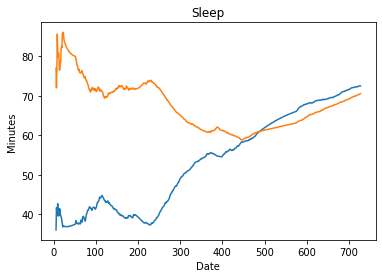

In [1029]:

plt.plot(df['REM_AVR'])
plt.plot(df['Deep Sleep_AVR'])

plt.title('Sleep')
plt.xlabel('Date')
plt.ylabel('Minutes');

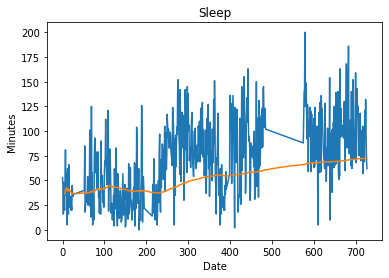

In [1030]:
plt.plot(df['REM'])
plt.plot(df['REM_AVR'])

plt.title('Sleep')
plt.xlabel('Date')
plt.ylabel('Minutes');

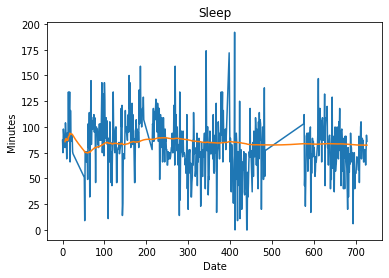

In [1031]:
plt.plot(df['Sleep Debt'])
plt.plot(df['Sleep Debt_AVR'])

plt.title('Sleep')
plt.xlabel('Date')
plt.ylabel('Minutes');

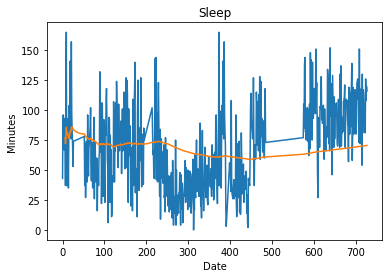

In [1032]:
plt.plot(df['Deep Sleep'])
plt.plot(df['Deep Sleep_AVR'])

plt.title('Sleep')
plt.xlabel('Date')
plt.ylabel('Minutes');

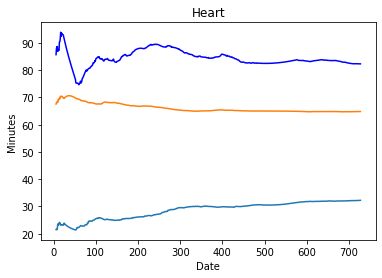

In [1033]:
plt.plot(df['Sleep Debt_AVR'],color="blue")
plt.plot(df['HRV_AVR'])
plt.plot(df['RHR_AVR'])
plt.title('Heart')
plt.xlabel('Date')
plt.ylabel('Minutes');


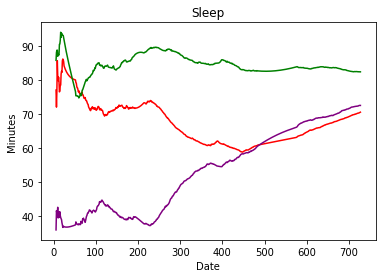

In [1034]:
plt.plot(df['Deep Sleep_AVR'],color="red")
plt.plot(df['Sleep Debt_AVR'],color="green")
plt.plot(df['REM_AVR'],color="purple")
plt.title('Sleep')
plt.xlabel('Date')
plt.ylabel('Minutes');

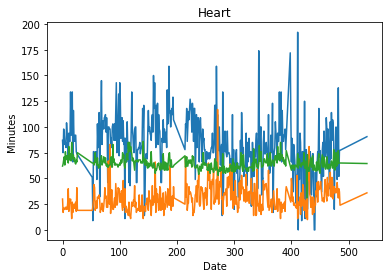

In [1035]:
plt.plot(train['Sleep Debt'])
plt.plot(train['HRV'])
plt.plot(train['RHR'])
plt.title('Heart')
plt.xlabel('Date')
plt.ylabel('Minutes');

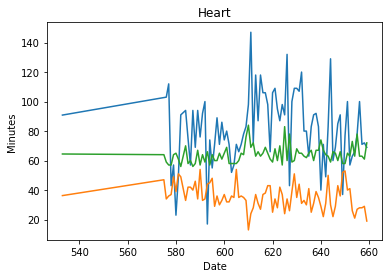

In [1036]:
plt.plot(val['Sleep Debt'])
plt.plot(val['HRV'])
plt.plot(val['RHR'])
plt.title('Heart')
plt.xlabel('Date')
plt.ylabel('Minutes');

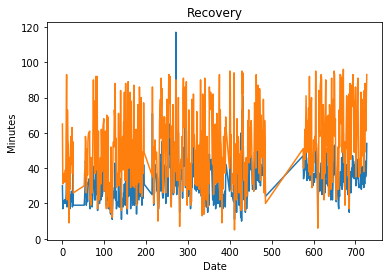

In [1037]:
plt.plot(df['HRV'])
plt.plot(df['Recovery'])
plt.title('Recovery')
plt.xlabel('Date')
plt.ylabel('Minutes');

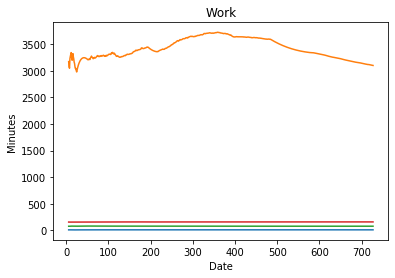

In [1038]:
plt.plot(df['Strain_AVR'])
plt.plot(df['Calories_AVR'])
plt.plot(df['AHR_AVR'])
plt.plot(df['MHR_AVR'])
plt.title('Work')
plt.xlabel('Date')
plt.ylabel('Minutes');

In [1039]:
df['Strain'] = np.log(df['Strain'])

In [1040]:
len(rf.feature_importances_)

52

In [1041]:
len(X_train.columns)


48

In [1042]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

ValueError: Length of passed values is 52, index implies 48

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
y_pred_proba = pipeline.predict_proba(X_val)[:, -1] # Probability for the last class
roc_auc_score(y_val, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})


import matplotlib.pyplot as plt
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');